In [9]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
from matplotlib import pyplot as plt
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss

for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [10]:
input_path = "/kaggle/input/icr-identify-age-related-conditions/"
work_path = os.getcwd()
df_train_file = pd.read_csv(input_path + 'train.csv')
df_greek_file = pd.read_csv(input_path + 'greeks.csv')
df_greek_file.sample(10)

,Id,Alpha,Beta,Gamma,Delta,Epsilon
479,c08f5a77f267,B,C,G,D,12/4/2018
299,7804b14ee22b,A,C,M,C,12/20/2018
505,cc9f47d89979,A,C,N,B,2/28/2020
160,3f4bfe72745d,D,B,E,A,7/30/2020
54,14713ec51d95,A,B,M,B,Unknown
265,68597a95792d,G,B,A,B,3/13/2019
553,e18129dade8f,A,C,M,C,11/27/2018
271,6955c8adcd36,A,B,M,A,5/5/2020
177,4537a9a3ecde,A,C,M,B,Unknown
197,4c92a971cf91,A,C,N,B,7/27/2020


In [11]:
def balance_loglossv2(y_true, y_pred):
    target_mean = y_true.mean()
    w0 = 1/(1-target_mean)
    w1 = 1/target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y_true]
    loss = log_loss(y_true, y_pred, sample_weight=sample_weight)
    
    return loss

In [12]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
competition_balanced_log_loss = make_scorer(balance_loglossv2, needs_proba=True, greater_is_better=False)
scores = []
grid_results = []

def compute_scores(clf, cv_strat, df_x, df_y, col_name):
    for i in ['accuracy', 'neg_log_loss', competition_balanced_log_loss]:
        scores.append([col_name, i, cross_val_score(clf, df_x, df_y, cv=cv_strat, scoring=i).mean()])
    return scores

In [13]:
def prepare_initial(df, df_greek_f, robust=True):
    df.sort_values(by=['Id'], axis=0, ascending=True, inplace=True)
    
    # training set labels
    df_y = None
    if 'Class' in df.columns:
      df_y = df['Class']
    
    # training set input
    df['EJ_dummy'] = (df['EJ'] == 'B')
    df['EJ_dummy'] = df['EJ_dummy'].astype('float64')
    temp_col = df['EJ_dummy']
    df_input = df.drop(['Id', 'EJ', 'EJ_dummy'], axis=1)
    if 'Class' in df.columns:
        df_input = df_input.drop(['Class'], axis=1)
    for i in df_input.columns:
        df_input[i].fillna(df_input[i].mode()[0], inplace=True)
    
    scaler = StandardScaler()
    if robust:
        scaler = RobustScaler()
    df_x = pd.DataFrame(scaler.fit_transform(df_input), columns=df_input.columns)
    df_x['EJ_dummy'] = temp_col
    
    # additional data
    df_greek_f.sort_values(by=['Id'], axis=0, ascending=True, inplace=True)
    df_greek_f.loc[df_greek_f['Epsilon'] == 'Unknown', 'Epsilon'] = pd.to_datetime('1/1/2021')
    df_greek_f['Epsilon_date'] = pd.to_datetime(df_greek_f.Epsilon)
    df_greek_f['Age'] = pd.to_datetime('1/1/2023') - df_greek_f.Epsilon_date
    df_greek_f['Age_days'] = df_greek_f['Age'].dt.total_seconds() / (24 * 60 * 60)
    
    scaler = StandardScaler()
    if robust:
        scaler = RobustScaler()
    df_greek_f[['Age_days']] = pd.DataFrame(scaler.fit_transform(df_greek_f[['Age_days']]), columns=['Age_days'])
    
    df_greek_x = pd.get_dummies(df_greek_f, columns = ['Alpha', 'Beta', 'Gamma', 'Delta'])
    df_greek_x = df_greek_x.drop(['Age_days', 'Alpha_A', 'Alpha_B', 'Alpha_D', 'Alpha_G', 'Age', 'Epsilon_date', 'Id', 'Epsilon'], axis=1)
    # Age_days must be dropped for RF multy categories

    return df_x, df_y, df_greek_x

In [14]:
df_ready_x, df_ready_y, df_ready_greek = prepare_initial(df_train_file, df_greek_file, True)
df_ready_x.sample(10)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ_dummy
291,-0.402778,-1.352741,0.000000,0.154507,3.083472,-0.092308,8.432432,-0.432943,1.122263,-0.119653,...,-0.469346,-0.624571,0.202899,0.048232,0.000000,3.530925,0.038062,1.871600,0.990161,0.0
172,-0.277778,-0.144669,0.000000,-0.367566,0.000000,-0.369231,0.000000,-0.757813,0.000000,-0.485549,...,-0.168051,-0.624571,-0.391304,0.099678,1.453384,-0.100212,-0.366153,-0.068766,-0.003123,1.0
180,-0.361111,-0.785231,2.479097,-0.475795,0.000000,-0.369231,0.000000,0.214844,0.000000,1.406894,...,-0.469346,0.346857,0.231884,1.768489,0.000000,-0.035118,0.326518,-0.069339,0.990161,0.0
417,0.847222,1.043715,1.137626,0.370101,0.000000,0.242308,0.000000,0.138021,0.000000,-0.269726,...,0.798512,-0.392857,0.376812,-0.079582,0.000000,0.765541,-0.280906,0.172803,-0.007574,1.0
241,-0.458333,-0.090938,0.000000,-0.302905,0.000000,-0.238462,0.000000,-1.208333,0.000000,-0.381753,...,0.376179,0.070857,-0.391304,-0.041801,0.000000,-0.354353,-0.100346,0.190438,-0.009843,1.0
466,-0.097222,1.576910,0.000000,-0.361342,0.000000,-0.711538,0.000000,-1.459635,0.000000,0.346052,...,0.182490,0.956857,1.101449,1.265273,0.000000,0.327891,0.419314,-0.224449,0.016745,1.0
514,-0.083333,-0.258154,0.000000,0.130705,0.000000,-0.573077,0.000000,0.035156,0.000000,-0.333185,...,0.823479,-0.424857,-0.391304,-0.131029,0.000000,-0.292632,0.112929,0.148354,-0.010568,1.0
439,-0.083333,0.327405,0.000000,0.298986,0.000000,0.603846,0.000000,0.526042,0.000000,0.728842,...,0.652074,0.052000,0.202899,1.232315,0.000000,-0.119858,0.566216,1.699571,-0.007901,1.0
422,0.916667,-1.181926,7.223985,2.935569,0.000000,0.890385,3.810811,-1.173177,0.000000,-0.284365,...,0.185168,-0.624571,1.173913,-1.102090,0.000000,-0.373542,-0.507078,-0.832808,-0.008795,1.0
120,-0.388889,1.900324,0.000000,-0.557169,0.000000,-0.146154,0.000000,-0.640625,0.000000,-0.977537,...,0.316712,-0.624571,-0.391304,-0.872990,1.435148,0.213671,-1.602391,-0.266934,0.001834,1.0


### Several models on train_x only

In [15]:
#from sklearn.svm import SVC

#clf = SVC(kernel='linear', C=1)
#compute_scores(clf, cv, df_ready_x, df_ready_y, 'SVC robust')
#0.876842381327039 with StandardScaler
#0.884959349593496 with RobustScaler

In [16]:
#from sklearn.ensemble import GradientBoostingClassifier

#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1).fit(df_ready_x, df_ready_y)
#compute_scores(clf, cv, df_ready_x, df_ready_y, 'GB robust')
#0.8849068974560714 with StandardScaler
#same with RobustScaler

In [17]:
params = {'max_depth': 10, 'max_features': 15, 'n_estimators': 30}

clf = RandomForestClassifier(**params).fit(df_ready_x, df_ready_y)
compute_scores(clf, cv, df_ready_x, df_ready_y, 'RF robust')
#0.8346708628376607 with StandardScaler
#same with RobustScaler

[['RF robust', 'accuracy', 0.9130387271614652],
 ['RF robust', 'neg_log_loss', -0.25267769159768977],
 ['RF robust',
  make_scorer(balance_loglossv2, greater_is_better=False, needs_proba=True),
  -0.4851965786848986]]

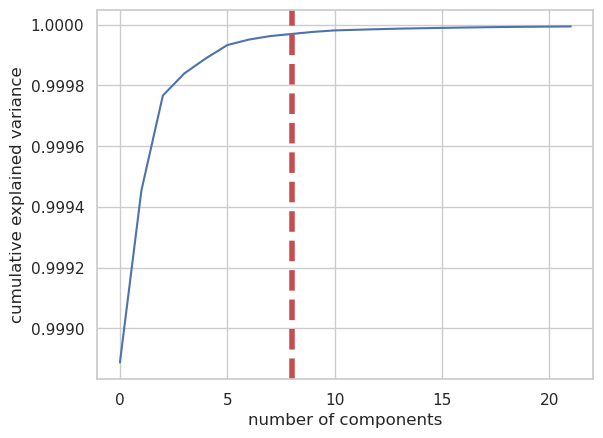

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.998887,0.998887
1,0.999454,0.000566
2,0.999767,0.000313
3,0.999840,0.000073
4,0.999889,0.000049
5,0.999933,0.000044
6,0.999951,0.000018
7,0.999963,0.000012
8,0.999970,0.000007
9,0.999977,0.000007


In [18]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=22)
pca_test.fit(df_ready_x)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=8, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [19]:
pca = PCA(n_components=22)
pca.fit(df_ready_x)
df_ready_x_pca = pca.transform(df_ready_x)

In [20]:
clf = RandomForestClassifier(**params)
clf.fit(df_ready_x_pca, df_ready_y)
compute_scores(clf, cv, df_ready_x_pca, df_ready_y, 'RF robust with PCA 22')

[['RF robust', 'accuracy', 0.9130387271614652],
 ['RF robust', 'neg_log_loss', -0.25267769159768977],
 ['RF robust',
  make_scorer(balance_loglossv2, greater_is_better=False, needs_proba=True),
  -0.4851965786848986],
 ['RF robust with PCA 22', 'accuracy', 0.8800463327213918],
 ['RF robust with PCA 22', 'neg_log_loss', -0.31406812666547257],
 ['RF robust with PCA 22',
  make_scorer(balance_loglossv2, greater_is_better=False, needs_proba=True),
  -0.6322613590840903]]

<Axes: xlabel='features', ylabel='accuracy'>

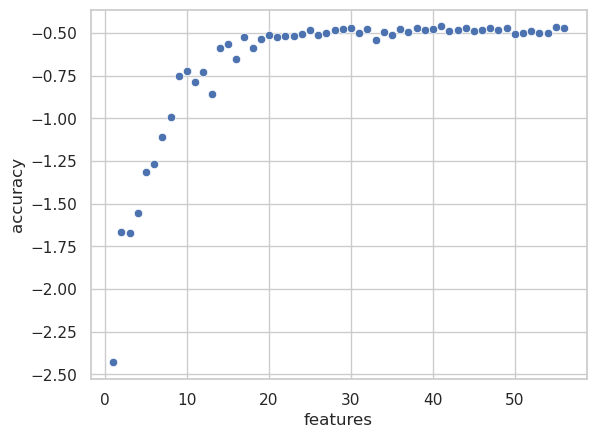

In [31]:
def find_best_features(df_x, df_y):
    clf = RandomForestClassifier(max_depth=13)
    clf.fit(df_x, df_y)
    forest_importances = pd.Series(clf.feature_importances_, index=df_x.columns)
    score = []
    for i in range(1, 57):
      top_features = list(forest_importances.nlargest(i).index)
      df_reduced_x = df_x.loc[:, top_features]
      clf = RandomForestClassifier(**params).fit(df_reduced_x, df_y)
      score.append([i, cross_val_score(clf, df_reduced_x, df_y, cv=cv, scoring=competition_balanced_log_loss).mean()])
    s = pd.DataFrame(score, columns=['features', 'balanced_log_loss'])
    return s
s = find_best_features(df_ready_x, df_ready_y)
sns.scatterplot(x='features', y='balanced_log_loss', data=s)

In [34]:
s.nlargest(3, columns=['balanced_log_loss'])

,features,accuracy
40,41,-0.461143
54,55,-0.465695
37,38,-0.468452


In [35]:
clf = RandomForestClassifier(**params).fit(df_ready_x, df_ready_y)
forest_importances = pd.Series(clf.feature_importances_, index=df_ready_x.columns)
top_features = list(forest_importances.nlargest(41).index)
df_reduced_x = df_ready_x.loc[:, top_features]
clf = RandomForestClassifier(**params).fit(df_reduced_x, df_ready_y)
compute_scores(clf, cv, df_ready_x_pca, df_ready_y, 'RF robust with 45 features')

[['RF robust', 'accuracy', 0.9130387271614652],
 ['RF robust', 'neg_log_loss', -0.25267769159768977],
 ['RF robust',
  make_scorer(balance_loglossv2, greater_is_better=False, needs_proba=True),
  -0.4851965786848986],
 ['RF robust with PCA 22', 'accuracy', 0.8800463327213918],
 ['RF robust with PCA 22', 'neg_log_loss', -0.31406812666547257],
 ['RF robust with PCA 22',
  make_scorer(balance_loglossv2, greater_is_better=False, needs_proba=True),
  -0.6322613590840903],
 ['RF robust with 27 features', 'accuracy', 0.8865635107963983],
 ['RF robust with 27 features', 'neg_log_loss', -0.3294313118762915],
 ['RF robust with 27 features',
  make_scorer(balance_loglossv2, greater_is_better=False, needs_proba=True),
  -0.6437326979111725],
 ['RF robust with 45 features', 'accuracy', 0.8865635107963982],
 ['RF robust with 45 features', 'neg_log_loss', -0.31586451883312194],
 ['RF robust with 45 features',
  make_scorer(balance_loglossv2, greater_is_better=False, needs_proba=True),
  -0.6368477636

In [36]:
top_features

['DU',
 'DA',
 'DI',
 'CR',
 'AB',
 'GL',
 'FL',
 'BC',
 'EH',
 'FR',
 'FD ',
 'CC',
 'DE',
 'AF',
 'FI',
 'EE',
 'FE',
 'CS',
 'CU',
 'BR',
 'DH',
 'BP',
 'DL',
 'CB',
 'AM',
 'EB',
 'EP',
 'AX',
 'CD ',
 'DY',
 'DN',
 'CH',
 'BD ',
 'FS',
 'EU',
 'GI',
 'BN',
 'DV',
 'AZ',
 'GF',
 'EG']

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=22)
pca_test.fit(df_reduced_x)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=8, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [ ]:
pca = PCA(n_components=14)
pca.fit(df_reduced_x)
df_ready_x_pca = pca.transform(df_reduced_x)

In [ ]:
clf = RandomForestClassifier(max_depth=13)
clf.fit(df_ready_x_pca, df_ready_y)
compute_scores(clf, cv, df_ready_x_pca, df_ready_y, 'RF robust with 27 features and PCA 14')

Same analysis with RF to greek

In [ ]:
clf = RandomForestClassifier(max_depth=3, random_state=0).fit(df_ready_x, df_ready_greek)
scores = cross_val_score(clf, cv, df_ready_x, df_ready_greek, cv=5)
print(scores.mean())

forest_importances = pd.Series(clf.feature_importances_, index=df_ready_x.columns)
scores = []
for i in range(1, 15):
  top_features = list(forest_importances.nlargest(i).index)
  df_reduced_x = df_ready_x.loc[:, top_features]
  clf = RandomForestClassifier(max_depth=3, random_state=0).fit(df_reduced_x, df_ready_greek)
  scores.append([i, cross_val_score(clf, cv, df_reduced_x, df_ready_greek, cv=5).mean()])
s = pd.DataFrame(scores, columns=['features', 'accuracy'])
s.nlargest(3, columns=['accuracy'])

In [ ]:
sns.scatterplot(x='features', y='accuracy', data=s)

### Same models on greek_x only

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, df_ready_greek, df_ready_y, cv=StratifiedKFold(n_splits=5))
scores.mean()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
scores = cross_val_score(clf, df_ready_greek, df_ready_y, cv=StratifiedKFold(n_splits=5))#, scoring='neg_log_loss')
scores.mean()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
#XGBClassifier(
#lgb', LGBMClassifier(random_state = seed, class_weight = 'balanced')),
#    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart', class_weight = 'balanced')),
#    ('cb', CatBoostClassifier(random_state = seed, verbose = 0, auto_class_weights = 'Balanced')),
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(df_ready_x, df_ready_y)
scores = cross_val_score(clf, df_ready_greek, df_ready_y, cv=StratifiedKFold(n_splits=5))#, scoring='neg_log_loss')
scores.mean()

feature importance in greek

In [ ]:
clf = RandomForestClassifier(max_depth=3, random_state=0).fit(df_ready_greek, df_ready_y)
scores = cross_val_score(clf, df_ready_greek, df_ready_y, cv=StratifiedKFold(n_splits=5))
print(scores.mean())

forest_importances = pd.Series(clf.feature_importances_, index=df_ready_greek.columns)
scores = []
for i in range(1, 16):
  top_features = list(forest_importances.nlargest(i).index)
  df_reduced_x = df_ready_greek.loc[:, top_features]
  clf = RandomForestClassifier(max_depth=3, random_state=0).fit(df_reduced_x, df_ready_y)
  scores.append([i, cross_val_score(clf, df_reduced_x, df_ready_y, cv=StratifiedKFold(n_splits=5)).mean()])
s = pd.DataFrame(scores, columns=['features', 'accuracy'])
s.nlargest(3, columns=['accuracy'])

In [ ]:
sns.scatterplot(x='features', y='accuracy', data=s)
len(df_ready_greek.columns)

### Trying PCA

In [ ]:
df_ready_x, df_ready_y, df_ready_greek = prepare_initial(df_train_file, df_greek_file)
clf = RandomForestClassifier(max_depth=13, random_state=0).fit(df_ready_x, df_ready_y)

forest_importances = pd.Series(clf.feature_importances_, index=df_ready_x.columns)
top_features = list(forest_importances.nlargest(22).index)
#top_features
df_reduced_x = df_ready_x.loc[:, top_features]
clf = RandomForestClassifier(max_depth=13, random_state=0).fit(df_reduced_x, df_ready_y)
scores = cross_val_score(clf, df_reduced_x, df_ready_y, cv=StratifiedKFold(n_splits=5))
print(scores.mean())



In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=22)
pca_test.fit(df_reduced_x)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=8, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [ ]:
pca = PCA(n_components=14)
pca.fit(df_reduced_x)
df_reduced_x_pca = pca.transform(df_reduced_x)

In [ ]:
clf = RandomForestClassifier(max_depth=13, random_state=0)
clf.fit(df_reduced_x_pca, df_ready_y)
scores = cross_val_score(clf, df_reduced_x_pca, df_ready_y, cv=StratifiedKFold(n_splits=5))
print(scores.mean())

Best accuracy 0.9141489640702858 with PCA 14, compared with 0.923866 no PCA only 22 features, 0.9157487542617361 without PCA and with all features

In [ ]:
def compute_scores(clf, df_x, df_y):
    scores = []
    for i in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss']:
        scores.append([i, cross_val_score(clf, df_x, df_y, cv=StratifiedKFold(n_splits=5), scoring=i).mean()])
    df_scores = pd.DataFrame(scores, columns=['metric', 'score'])
    print(df_scores)
    return df_scores

## conclusion: 
* greek is more predictive of Class than the train file
* Alpha_A is Class=0, Alpha_B, Alpha_D and Alpha_G are class=1 They are what we want to predict
* using RobustScaler instead of StandardScaler to take care of outliers
* best accuracy in from train to class is 4
* best accuracy in from train to greek is 8
* best accuracy in from greek to class is 10 (8 is close)
* best accuracy with max_depth of 3, very different with 13 (best for train to class)
* Random Forest depth has big impact but risk of overfitting
* PCA unclear if usefull
* for RF: criterion = 'log_loss', class_weight = 'balanced')
* RidgeClassifier for ensemble
* TODO
  * try GBM with balancing set XGBClassifier(scale_pos_weight=4.71)
  * let's use a random forest to predict Gamma_M and Gamma_N and then Class with SGB
  * find most interesting features through RF
  * find the right compromise from greek and train features for best overall accuracy
  * add MLPClassifier(random_state = seed, max_iter = 1000000) to ensemble